In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, GRU, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
# Load Data
def load_file(file):
    data = pd.read_csv(file)
    data.drop(columns=['Unnamed: 0'], inplace=True)
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    return data

file = 'question4-stock-data.csv'
data = load_file(file)

In [3]:
# Fill Missing Values Using Rolling Mean (5-day window)
def fill_missing(data):
    data['Temp'] = data['Close'].rolling(window=5, min_periods=1).mean()
    data['Close'].fillna(data['Temp'], inplace=True)
    data.drop(columns=['Temp'], inplace=True)
    return data

data = fill_missing(data)

C:\Users\lokud\AppData\Local\Temp\ipykernel_25720\3647735383.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Close'].fillna(data['Temp'], inplace=True)


**Plot Graphs**


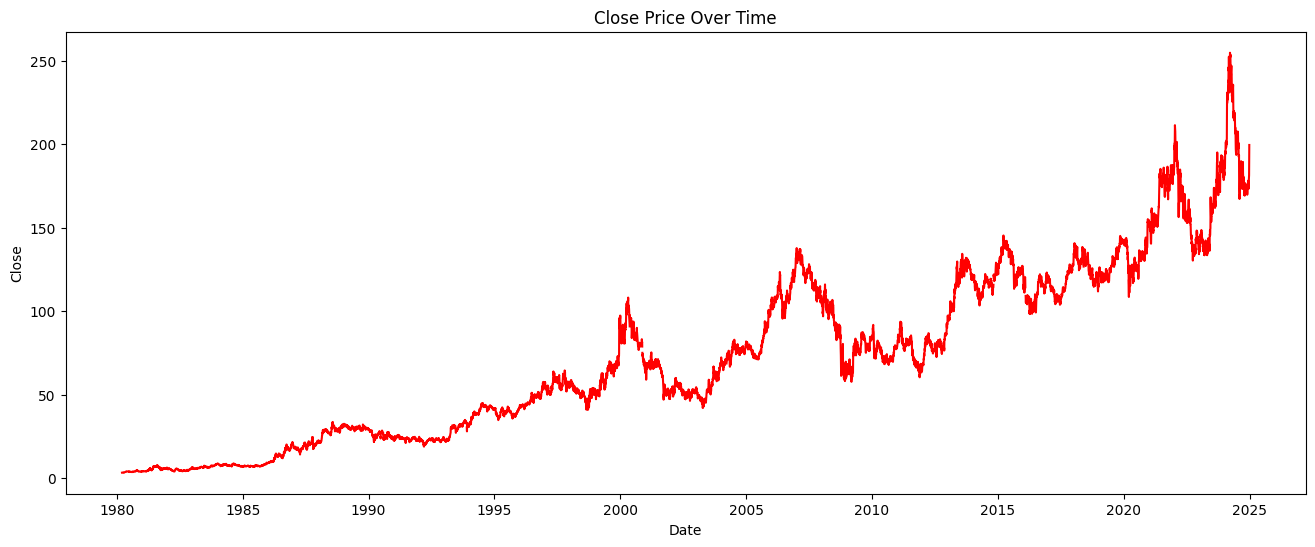

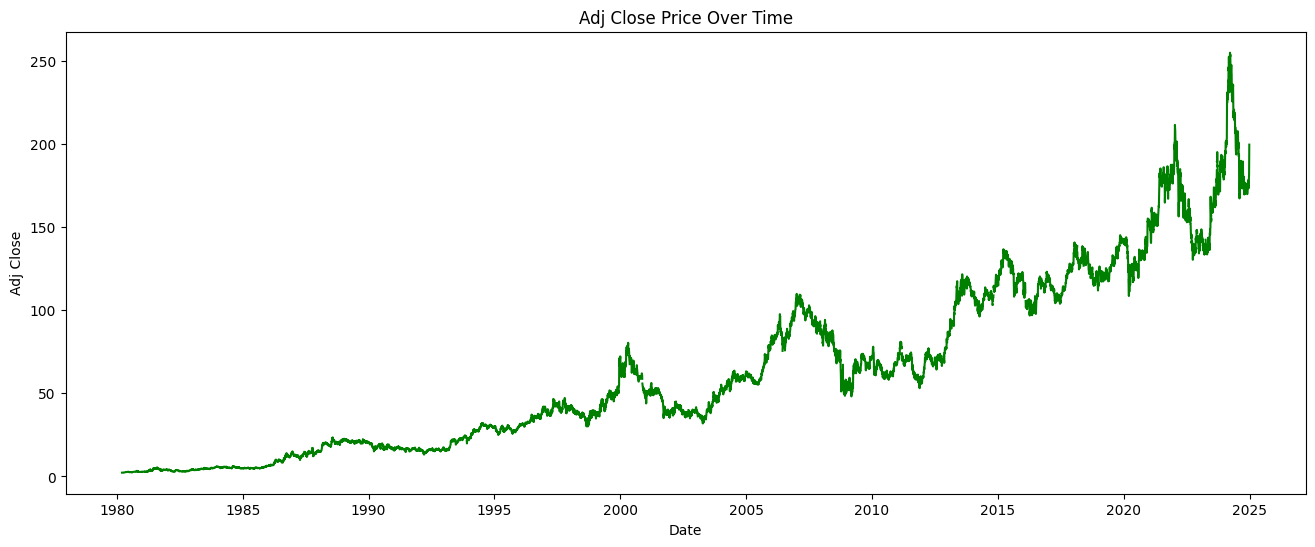

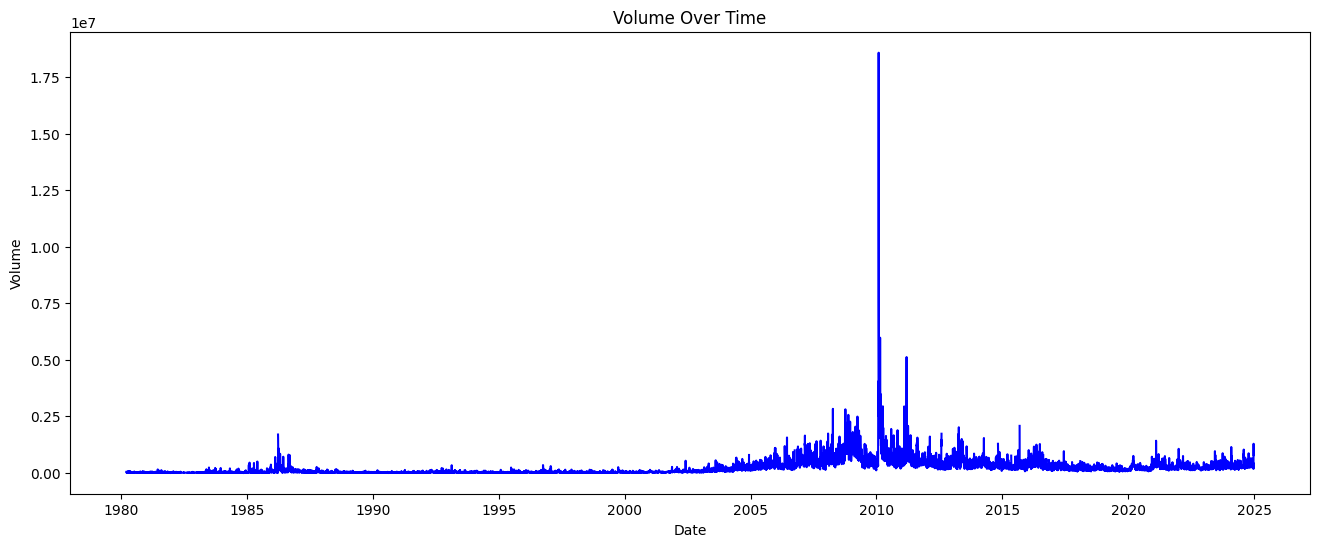

In [4]:
def plot_graph(data, column, color, title):
    plt.figure(figsize=(16, 6))
    plt.plot(data[column], color=color)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.show()

plot_graph(data, 'Close', 'red', 'Close Price Over Time')
plot_graph(data, 'Adj Close', 'green', 'Adj Close Price Over Time')
plot_graph(data, 'Volume', 'blue', 'Volume Over Time')

**Feature Scaling**

In [5]:

def scale_data(values):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    return scaled, scaler

values = data[['Close']].values
scaled, scaler = scale_data(values)


**Create Training Data**

In [6]:
def create_train_data(scaled, seq_len):
    x_train, y_train = [], []
    for i in range(seq_len, len(scaled)):
        x_train.append(scaled[i-seq_len:i, 0])
        y_train.append(scaled[i, 0])
    return np.array(x_train), np.array(y_train)

**Sequence Lengths (30, 50, 60, 70) - Testing Different Lengths**

In [7]:

seq_len = 60
x_train, y_train = create_train_data(scaled, seq_len)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

**Model Variations**

*LSTM with dropout and more dense layers*

In [8]:

def make_lstm(shape):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=shape))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))
    return model

**Bidirectional LSTM**

In [9]:
def make_bidirectional_lstm(shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=shape))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64, return_sequences=False)))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))
    return model

**GRU**


In [10]:
def make_gru(shape):
    model = Sequential()
    model.add(GRU(128, return_sequences=True, input_shape=shape))
    model.add(Dropout(0.2))
    model.add(GRU(64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))
    return model

**Final used model**

In [11]:
def make_model(shape):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=shape))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    return model

**Compile and Train Model**


In [12]:
def train_model(model, x_train, y_train):
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, verbose=1)
    early_stop = EarlyStopping(monitor='loss', patience=5)
    history = model.fit(x_train, y_train, batch_size=16, epochs=20, callbacks=[early_stop, reduce_lr])
    return history

*without Earlystopping and ReduceLROnPlateau(final model use)*

In [13]:
def train_model_2(model, x_train, y_train):
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    history = model.fit(x_train, y_train, batch_size=8, epochs=10)
    return history

In [14]:
# Build and Train Model
model = make_model((x_train.shape[1], 1))
train_model_2(model, x_train, y_train)

C:\Users\lokud\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 49s 28ms/step - loss: 0.0013
Epoch 2/10
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 44s 31ms/step - loss: 1.4070e-04
Epoch 3/10
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 50s 28ms/step - loss: 1.1146e-04
Epoch 4/10
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 50s 36ms/step - loss: 7.4525e-05
Epoch 5/10
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 42s 29ms/step - loss: 7.3417e-05
Epoch 6/10
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 38s 27ms/step - loss: 6.8866e-05
Epoch 7/10
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 40s 28ms/step - loss: 5.5427e-05
Epoch 8/10
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 35s 24ms/step - loss: 6.4608e-05
Epoch 9/10
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 43s 31ms/step - loss: 5.6697e-05
Epoch 10/10
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 37s 26ms/step - loss: 5.3102e-05


In [12]:
# Build and Train Model
model = make_lstm((x_train.shape[1], 1))
train_model(model, x_train, y_train)

C:\Users\lokud\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 34s 34ms/step - loss: 0.0039 - learning_rate: 0.0010
Epoch 2/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 24s 33ms/step - loss: 4.4662e-04 - learning_rate: 0.0010
Epoch 3/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 26s 37ms/step - loss: 3.7918e-04 - learning_rate: 0.0010
Epoch 4/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - loss: 3.7290e-04 - learning_rate: 0.0010
Epoch 5/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 3.6064e-04
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
702/702 ━━━━━━━━━━━━━━━━━━━━ 26s 37ms/step - loss: 3.6067e-04 - learning_rate: 0.0010
Epoch 6/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step - loss: 3.3763e-04 - learning_rate: 5.0000e-04
Epoch 7/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 26s 37ms/step - loss: 3.2343e-04 - learning_rate: 5.0000e-04
Epoch 8/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - loss: 3.2159e-04 - learning_rate: 5.0000e-04
Epoch 9/20
701/702 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 3.1557e-04
Epoch 9

**Prediction and Evaluation**

In [15]:

def create_test_data(scaled, train_len, seq_len):
    test_set = scaled[train_len - seq_len:, :]
    x_test = []
    for i in range(seq_len, len(test_set)):
        x_test.append(test_set[i-seq_len:i, 0])
    return np.array(x_test)

train_len = int(np.ceil(len(values) * .99))
x_test = create_test_data(scaled, train_len, seq_len)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = values[train_len:, :]

predicted_close = model.predict(x_test)
predicted_close = scaler.inverse_transform(predicted_close)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step


 **Evaluation Metrics**

*final used model-model evaluation*

In [16]:

from sklearn.metrics import mean_absolute_error

rmse = np.sqrt(np.mean(((predicted_close - y_test) ** 2)))
mae = mean_absolute_error(y_test, predicted_close)
directional_accuracy = np.mean((np.sign(predicted_close[1:] - predicted_close[:-1]) == np.sign(y_test[1:] - y_test[:-1])))

print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'Directional Accuracy: {directional_accuracy * 100:.2f}%')

RMSE: 3.6548
MAE: 2.6504
Directional Accuracy: 49.55%


*different model-model evaluation(for example)*

In [14]:

from sklearn.metrics import mean_absolute_error

rmse = np.sqrt(np.mean(((predicted_close - y_test) ** 2)))
mae = mean_absolute_error(y_test, predicted_close)
directional_accuracy = np.mean((np.sign(predicted_close[1:] - predicted_close[:-1]) == np.sign(y_test[1:] - y_test[:-1])))

print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'Directional Accuracy: {directional_accuracy * 100:.2f}%')

RMSE: 4.2791
MAE: 2.9241
Directional Accuracy: 46.85%


**Plot Results**

C:\Users\lokud\AppData\Local\Temp\ipykernel_25720\3549816454.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_Close'] = predicted_close


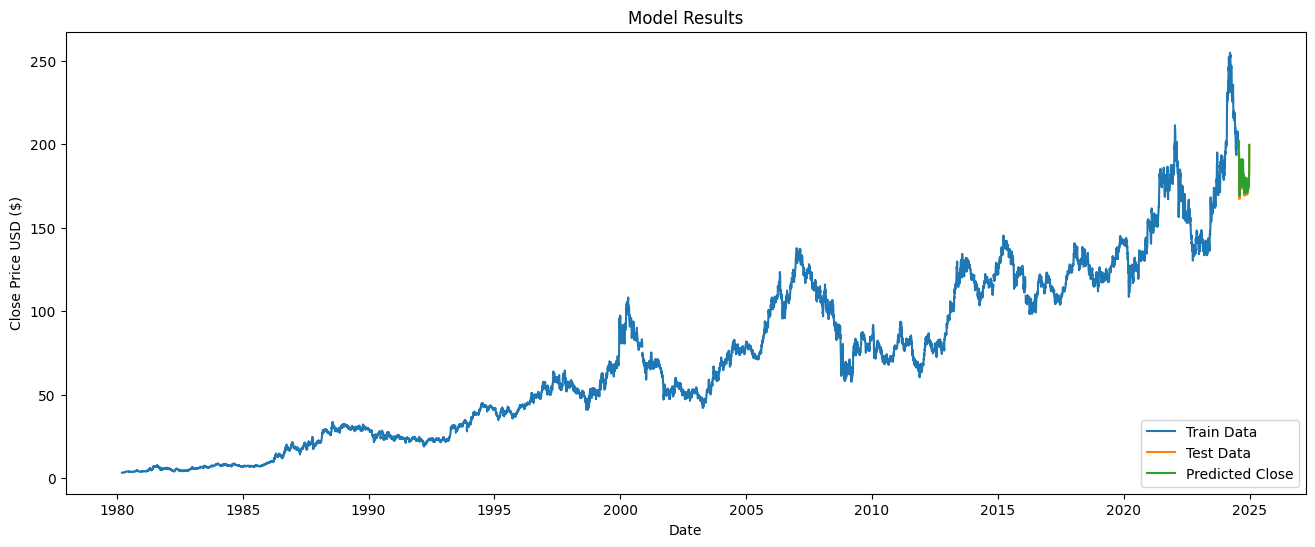

In [17]:

def plot_results(train_data, test_data):
    plt.figure(figsize=(16, 6))
    plt.plot(train_data['Close'])
    plt.plot(test_data[['Close', 'Predicted_Close']])
    plt.title('Model Results')
    plt.xlabel('Date')
    plt.ylabel('Close Price USD ($)')
    plt.legend(['Train Data', 'Test Data', 'Predicted Close'], loc='lower right')
    plt.show()

train_data = data[:train_len]
test_data = data[train_len:]
test_data['Predicted_Close'] = predicted_close
plot_results(train_data, test_data)

**Prediction for Next 5 Days**

In [18]:

def predict_next_days(model, last_data, seq_len, scaler):
    input_data = last_data[-seq_len:].reshape(1, seq_len, 1)
    predicted = []
    for _ in range(5):
        pred = model.predict(input_data)[0][0]
        predicted.append(pred)
        input_data = np.append(input_data[:, 1:, :], [[[pred]]], axis=1)
    return scaler.inverse_transform(np.array(predicted).reshape(-1, 1))

predicted_next_5 = predict_next_days(model, scaled, seq_len, scaler)

print('Predicted next 5 days close price:')
print(predicted_next_5)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted next 5 days close price:
[[200.5243 ]
 [201.29904]
 [201.97197]
 [202.63661]
 [203.34831]]


**Plot Results**

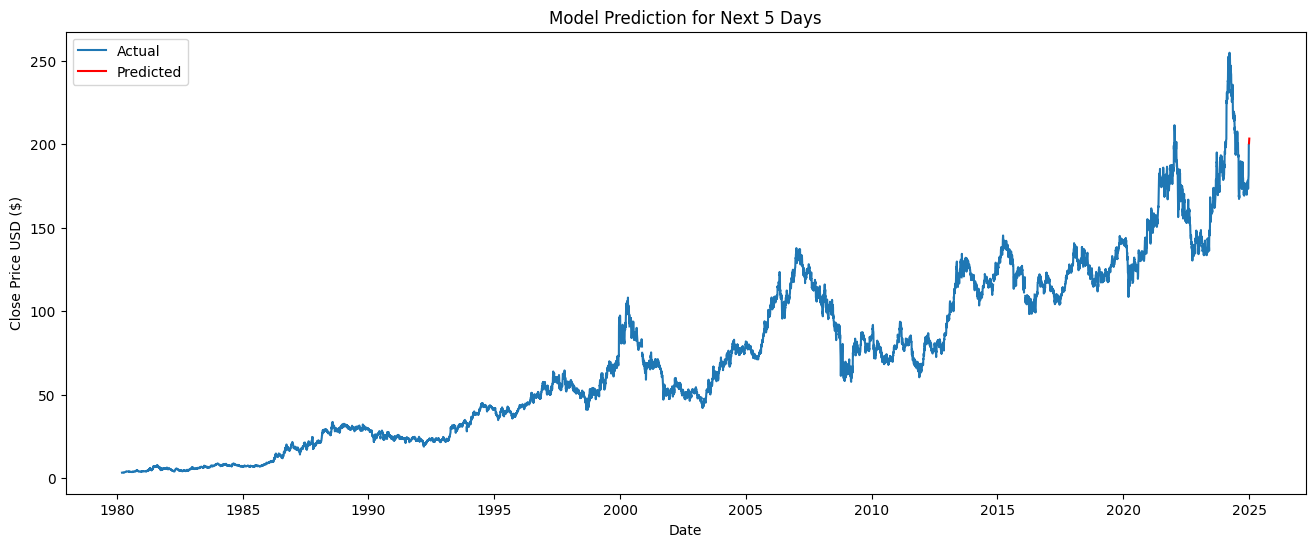

In [19]:

def plot_results(data, predicted_next_5):
    plt.figure(figsize=(16, 6))
    plt.plot(data['Close'], label='Actual')
    future_dates = pd.date_range(start=data.index[-1], periods=6, freq='B')[1:]
    plt.plot(future_dates, predicted_next_5, label='Predicted', color='red')
    plt.title('Model Prediction for Next 5 Days')
    plt.xlabel('Date')
    plt.ylabel('Close Price USD ($)')
    plt.legend()
    plt.show()

plot_results(data, predicted_next_5)

In [20]:
import os

os.makedirs('saved_model', exist_ok=True)

# Save the model as .keras file
model.save('saved_model/stock_model.keras')